### Explore the environment

- Goal is to solve the [reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment from Unity
- A double jointed arm can move to target locations
- A **reward of +0.1** is provided for each step, where the agent's hand is in the goal location
- The **state space is comprised of 33 variables**; corresponding to position, rotation, velocity & angular velocities
- **Action space is a vector of 4 numbers** having an entry b/w **+1 and -1**
- **Solving : +30 avg. reward over 100 episodes**

![Reacher.gif](reacher.gif)

In [2]:
from unityagents import UnityEnvironment

In [3]:
env = UnityEnvironment(file_name='./Reacher_Linux_NoVis/Reacher.x86')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# Get the default brain 
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# Explore the env state and action space
env_info = env.reset(train_mode=True)[brain_name]
# Num of agents
num_agents = len(env_info.agents)
print("# of Agents : {}".format(num_agents))
# State space 
state_size = env_info.vector_observations.shape
print("State Size  : {}".format(state_size))
# Action size
action_size = brain.vector_action_space_size
print("Action Size : {}".format(action_size))

# of Agents : 20
State Size  : (20, 33)
Action Size : 4


In [6]:
# To close the environment
#env.close()

### Imports

In [7]:
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# replaybuffer imports
from collections import namedtuple, deque
import random
import numpy as np
import copy

# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Theoretical Notes

- DDPG uses stochastic behavior policy for exploration but estimates a deterministic target policy, which is easier to learn
- Using correlated experiences leads to vast amount of variance in the approximation of the Q function
- Thus using Experience buffer to store experiences and sample them randomly for learning in order to break the temporal correlations within epsiodes
- Directly updating the Actor and Critic networks in DDPG causes learning algorithm to diverge
- Using target networks for both Actor and Critic increases the stability.
- The **TD target** and **loss function for the critic network** have equations:
$${y_i} = {r_i} + \gamma{Q'(s_{i+1}, \mu'(s_{i+1}|{\theta^{\mu'}})|{\theta^{Q'}})}$$
$$L = \frac{1}{N} \sum_{i}(y_i - Q(s_i, a_i|\theta^Q)^2)$$
where,
$$N - \text{is the size of minibatch sampled}$$
$$\theta^{\mu'} - \text{weights of the target actor network}$$
$$\theta^{Q'} - \text{weights of the target critic network}$$
- The critic policy can be updated with the gradients from the loss function above
- The actor network is updated with the deterministic policy gradient
- [David Silver](http://proceedings.mlr.press/v32/silver14.pdf) proves that the gradient of the stochastic and deterministic policy is the equivalent
$$ \nabla_{\theta\mu}\mu\approx\mathbb{E}_{\mu'}[\nabla_aQ(s, a|\theta^Q)|_{s={s_t}, a=\mu({s_t})} \nabla_{\theta^\mu}\mu(s|\theta^\mu)|_{s={s_t}}$$
- **All this means is that we need gradients of the output of the critic network multiplied by the gradient of the output of the actor network w.r.t. it's parameters, averaged over a minibatch**

### Models for Actor and Critic

In [8]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc1=256, fc2=128, leak=0.01):
        """ Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_size (int): Number of nodes in hidden layers
            leak: amount of leakiness in leaky relu
        """
        super(Actor, self).__init__()
        self.leak = leak
        
        self.fc1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, action_size)

        self.bn = nn.BatchNorm1d(state_size)
        self.reset_parameters()

    def reset_parameters(self):
        """ Initilaize the weights using He et al (2015) weights """
        torch.nn.init.kaiming_normal_(self.fc1.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.kaiming_normal_(self.fc2.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.uniform_(self.fc3.weight.data, -3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        state = self.bn(state)
        x = F.leaky_relu(self.fc1(state), negative_slope=self.leak)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.leak)
        x =  torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_size, action_size, fc1=256, fc2=128, fc3=128, leak=0.01):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            hidden_size:
        """
        super(Critic, self).__init__()
        self.leak = leak
        self.bn = nn.BatchNorm1d(state_size)
        self.fcs1 = nn.Linear(state_size, fc1)
        self.fc2 = nn.Linear(fc1 + action_size, fc2)
        self.fc3 = nn.Linear(fc2, fc3)
        self.fc4 = nn.Linear(fc3, 1)
        self.reset_parameters()

    def reset_parameters(self):
        """ Initilaize the weights using He et al (2015) weights """
        torch.nn.init.kaiming_normal_(self.fcs1.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.kaiming_normal_(self.fc2.weight.data, a=self.leak, mode='fan_in')
        torch.nn.init.uniform_(self.fc3.weight.data, -3e-3, 3e-3)

    def forward(self, state, action):
        """ Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        state = self.bn(state)
        x = F.leaky_relu(self.fcs1(state), negative_slope=self.leak)
        x = torch.cat((x, action), dim=1)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.leak)
        x = F.leaky_relu(self.fc3(x), negative_slope=self.leak)
        x =  self.fc4(x)
        return x


### Replay Buffer

- The replay buffer is used to solve the problem of correlation bw episodes used for learning since we randomly sample experiences to learn from

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Ornstein-Uhlenbeck Process
- Since the policy is deterministic, it can produce the same actions
- For exploration we add additive noise to deterministic action to explore the action
- To generate the correlated noise we use OU process given by equation
$$ dx_t = \theta(\mu - x_t) + \sigma dW_t$$  
$$ \text{where,  } dW_t = \mathcal{N}(0, dt)$$
$$ \mu = \text{mean of the process}$$
$$ \theta = \text{friction, how fast it varies with noise} $$
$$ \sigma = \text{controls the amount of random noise} $$

In [10]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### Agent Class

In [11]:
# Hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1024       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay
LEAKINESS = 0.01

In [12]:
class Agent():
    
    def __init__(self, state_size, action_size, n_agents=1):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            n_agents: number of agents it will control in the environment
        """
        self.state_size = state_size
        self.action_size = action_size
        self.n_agents = n_agents

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, leak=LEAKINESS).to(device)
        self.actor_target = Actor(state_size, action_size, leak=LEAKINESS).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, leak=LEAKINESS).to(device)
        self.critic_target = Critic(state_size, action_size, leak=LEAKINESS).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)
        # self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        self.timesteps = 0  

    
    def step(self, states, actions, rewards, next_states, dones):
        """ Given a batch of S,A,R,S' experiences, it saves them into the
            experience buffer, and occasionally samples from the experience
            buffer to perform training steps.
        """
        self.timesteps += 1
        for i in range(self.n_agents):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])

        if (len(self.memory) > BATCH_SIZE) and (self.timesteps % 20 == 0):
            for _ in range(10):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            actions = actions + [self.noise.sample() for _ in range(self.n_agents)]
        return np.clip(actions, -1, 1)

    
    def reset(self):
        self.noise.reset()

    
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Train loop

In [13]:
state_size = 33
action_size = 4
num_agents = 20

# Create agent
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents)

In [14]:
def ddpg(n_episodes=2000, max_t=1000, window_size=100, score_threshold=30.0, 
         print_interval=10, episodes=1000):

    scores_deque = deque(maxlen=window_size) 
    scores = []        
    best_average_score = 0
    
    for i_episode in range(1, episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            #print(f"Reward : {rewards}")
            agent.step(states=states, actions=actions, rewards=rewards, next_states=next_states, dones=dones)
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break

        episode_score = np.mean(episode_scores)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_interval == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if average_score >= score_threshold:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            torch.save(agent.actor_local.state_dict(), 'actor.ckpt')
            torch.save(agent.critic_local.state_dict(), 'critic.ckpt')
            break

    np.save('scores.npy', scores)
    return scores

In [15]:
scores = ddpg()

Episode: 10	Average Score: 0.51	Current Score: 0.95
Episode: 20	Average Score: 0.75	Current Score: 1.05
Episode: 30	Average Score: 0.98	Current Score: 1.88
Episode: 40	Average Score: 1.40	Current Score: 2.94
Episode: 50	Average Score: 1.87	Current Score: 4.35
Episode: 60	Average Score: 2.39	Current Score: 5.00
Episode: 70	Average Score: 2.77	Current Score: 5.22
Episode: 80	Average Score: 3.23	Current Score: 6.51
Episode: 90	Average Score: 3.71	Current Score: 9.58
Episode: 100	Average Score: 4.29	Current Score: 10.12
Episode: 110	Average Score: 5.14	Current Score: 9.00
Episode: 120	Average Score: 6.10	Current Score: 12.28
Episode: 130	Average Score: 7.28	Current Score: 14.71
Episode: 140	Average Score: 8.66	Current Score: 18.87
Episode: 150	Average Score: 10.37	Current Score: 20.98
Episode: 160	Average Score: 12.11	Current Score: 21.47
Episode: 170	Average Score: 13.95	Current Score: 26.43
Episode: 180	Average Score: 15.86	Current Score: 25.15
Episode: 190	Average Score: 17.68	Current S

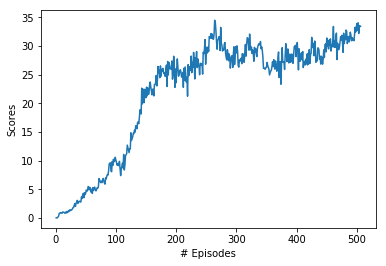

In [16]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.savefig('scores_plot.png')
plt.show()

### References:

[Patrick Emami - Deep Deterministic Policy Gradients in TensorFlow](http://proceedings.mlr.press/v32/silver14.pdf)   
[David Silver - Deep deterministic Policy Gradients (**Theory**)](http://proceedings.mlr.press/v32/silver14.pdf)   
[Julian Vitey - Deep RL (**DDPG algorithm**)](https://julien-vitay.net/deeprl/DeepRL.pdf)